In [328]:
LESSON_HOME = '/Users/chekalin/Dev/fastai/fast-ai-homework/lesson1hw'
DATA_HOME = LESSON_HOME + '/data'
%cd $LESSON_HOME

/Users/chekalin/Dev/fastai/fast-ai-homework/lesson1hw


Download dataset from kaggle using [kaggle-cli](https://github.com/floydwch/kaggle-cli) into data/ folder and unzip it
```bash
kg download -c dogs-vs-cats-redux-kernels-edition
unzip train.zip; unzip test.zip
```

Expected structure:
```
data/
├── sample_submission.csv
├── test
│   ├── 1.jpg
│   ├── 10.jpg
│   ├── 100.jpg
│   ...
├── test.zip
├── train
│   ├── cat.0.jpg
│   ├── cat.1.jpg
│   ├── cat.10.jpg
│   ├── cat.100.jpg
│   ├── cat.1000.jpg
│   ├── cat.10000.jpg
│   ├── cat.10001.jpg
│   ...  
│   ├── dog.9996.jpg
│   ├── dog.9997.jpg
│   ├── dog.9998.jpg
│   └── dog.9999.jpg
└── train.zip
```

In [329]:
%mkdir -p $DATA_HOME/sample/train
%mkdir -p $DATA_HOME/sample/valid
%mkdir -p $DATA_HOME/sample/test
%mkdir -p $DATA_HOME/sample/results
%mkdir -p $DATA_HOME/valid
%mkdir -p $DATA_HOME/results

# Create Validation Set and Sample

In [330]:
% cd $DATA_HOME/train

/Users/chekalin/Dev/fastai/fast-ai-homework/lesson1hw/data/train


In [331]:
from glob import glob
import numpy as np
import os

training_files = glob('*.jpg')
validation_set_size = int(len(training_files) * .2)

shuffled_training_files = np.random.permutation(training_files)
for i in range(validation_set_size): os.rename(shuffled_training_files[i], DATA_HOME + '/valid/' + training_files[i])

In [332]:
from shutil import copyfile
from random import shuffle

training_files = glob('*.jpg')
shuffle(training_files)
sample_train_size = 240
sample_valid_size = int(sample_train_size / 3)

for i in range(sample_train_size): 
    random_file = training_files.pop()
    copyfile(random_file, DATA_HOME + '/sample/train/' + random_file)

for i in range(sample_valid_size): 
    random_file = training_files.pop()
    copyfile(random_file, DATA_HOME + '/sample/valid/' + random_file)

In [333]:
% cd $DATA_HOME/test

/Users/chekalin/Dev/fastai/fast-ai-homework/lesson1hw/data/test


In [334]:
test_files = glob('*.jpg')
shuffle(test_files)

sample_test_size = int(sample_train_size / 3);

for i in range(sample_test_size): 
    random_file = test_files.pop()
    copyfile(random_file, DATA_HOME + '/sample/test/' + random_file)

# Sort each folder by label

In [335]:
def move_to_label_folders(base_folder):
    % cd $base_folder
    % mkdir -p cats
    % mv cat.*.jpg cats/
    % mkdir -p dogs
    % mv dog.*.jpg dogs/
    
def move_all_to_unknown_folder(base_folder):
    % cd $base_folder
    % mkdir -p unknown
    % mv *.jpg unknown/

In [336]:
move_to_label_folders(DATA_HOME + '/sample/train');
move_to_label_folders(DATA_HOME + '/sample/valid');
move_all_to_unknown_folder(DATA_HOME + '/sample/test');

move_to_label_folders(DATA_HOME + '/train');
move_to_label_folders(DATA_HOME + '/valid');
move_all_to_unknown_folder(DATA_HOME + '/test');

/Users/chekalin/Dev/fastai/fast-ai-homework/lesson1hw/data/sample/train
/Users/chekalin/Dev/fastai/fast-ai-homework/lesson1hw/data/sample/valid
/Users/chekalin/Dev/fastai/fast-ai-homework/lesson1hw/data/sample/test
/Users/chekalin/Dev/fastai/fast-ai-homework/lesson1hw/data/train
/Users/chekalin/Dev/fastai/fast-ai-homework/lesson1hw/data/valid
/Users/chekalin/Dev/fastai/fast-ai-homework/lesson1hw/data/test


Verify directory structure is correct

In [337]:
% cd $DATA_HOME

/Users/chekalin/Dev/fastai/fast-ai-homework/lesson1hw/data


In [338]:
for dirpath, dirnames, filenames in os.walk(DATA_HOME):
    relative = dirpath[len(os.getcwd()):]
    if (len(filenames)): print "Files in {}: {}".format(relative, len(filenames))


Files in : 3
Files in /valid/dogs: 2508
Files in /valid/cats: 2492
Files in /test/unknown: 12500
Files in /sample/valid/dogs: 38
Files in /sample/valid/cats: 42
Files in /sample/test/unknown: 80
Files in /sample/train/dogs: 112
Files in /sample/train/cats: 128
Files in /train/dogs: 10025
Files in /train/cats: 9975


# Train model

In [339]:
% cd $LESSON_HOME

/Users/chekalin/Dev/fastai/fast-ai-homework/lesson1hw


In [340]:
import vgg16

reload(vgg16)
from vgg16 import Vgg16

import math
import csv
import time

In [341]:
batch_size = 64
no_of_epochs = 1
# path = DATA_HOME
path = DATA_HOME + '/sample'
results_path = path + '/results'

In [342]:
vgg = Vgg16()
batches = vgg.get_batches(path + '/train', batch_size=batch_size)
val_batches = vgg.get_batches(path + '/valid', batch_size=batch_size)

Found 240 images belonging to 2 classes.
Found 80 images belonging to 2 classes.


In [343]:
vgg.finetune(batches)

In [344]:
latest_weights_filename = None
fitting_start_time = time.time()
for epoch in range(no_of_epochs):
    epoch_start_time = time.time()
    vgg.fit(batches, val_batches, nb_epoch=1)
    latest_weights_filename = results_path + '/ft{}.h5'.format(epoch)
    vgg.model.save_weights(latest_weights_filename)
    print "processing batch {} of {} batches took {} seconds".format(epoch,
                                                                     no_of_epochs,
                                                                     int(time.time() - epoch_start_time))
print "fitting took {} seconds".format(int(time.time() - fitting_start_time))

Epoch 1/1
240/240 [==============================] - 94s - loss: 1.1843 - acc: 0.6250 - val_loss: 0.1261 - val_acc: 0.9500
processing batch 0 of 1 batches took 99 seconds
fitting took 99 seconds


# Predicitons

In [382]:
# we can continue from this step if we already previously trained model
vgg.model.load_weights(latest_weights_filename)

In [383]:
test_path = path + '/valid'
test_batches = vgg.get_batches(test_path, batch_size=batch_size, shuffle=False)

Found 80 images belonging to 2 classes.


In [384]:
predicting_start_time = time.time()
predictions = vgg.model.predict_generator(test_batches, test_batches.nb_sample)
print 'Prediction took {}s'.format(int(time.time() - predicting_start_time))

Prediction took 25s


In [385]:
probabilities_of_dog = predictions[:,1]

In [386]:
from keras.preprocessing import image
from utils import plots
from random import sample
%matplotlib inline

def plot_idxs(idxs, titles=None):
    if (len(idxs) == 0): return
    if (len(idxs) > 4): idxs = sample(idxs, 4)
    images = [image.load_img(test_path + "/" + test_batches.filenames[i]) for i in idxs]
    plots(images, titles=probabilities_of_dog[idxs])    

In [387]:
actual_classes = test_batches.classes
predicted_classes = np.array([int(round(probability)) for probability in probabilities_of_dog])

4 wrong predictions found


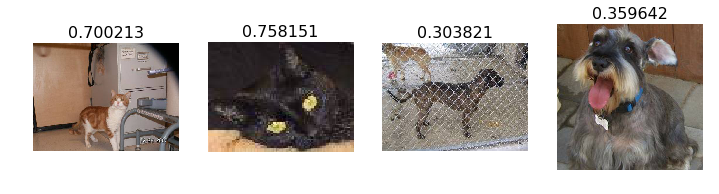

In [388]:
idxs = np.where(actual_classes != predicted_classes)[0]
print '{} wrong predictions found'.format(len(idxs))
plot_idxs(idxs)

76 correct predictions found


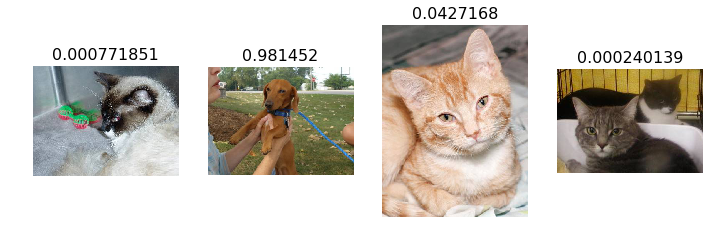

In [389]:
idxs = np.where(actual_classes == predicted_classes)[0]
print '{} correct predictions found'.format(len(idxs))
plot_idxs(idxs)

40 correct cats found


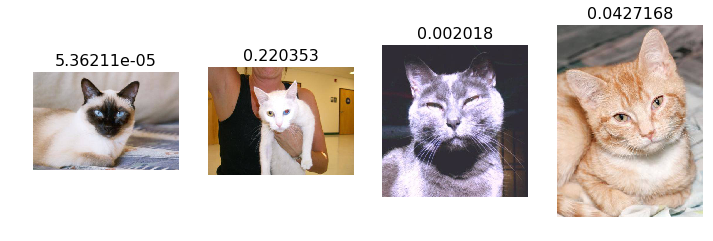

In [390]:
correct_cats = np.where((predicted_classes==0) & (predicted_classes==actual_classes))[0]
print '{} correct cats found'.format(len(correct_cats))
plot_idxs(correct_cats)

2 incorrect cats found


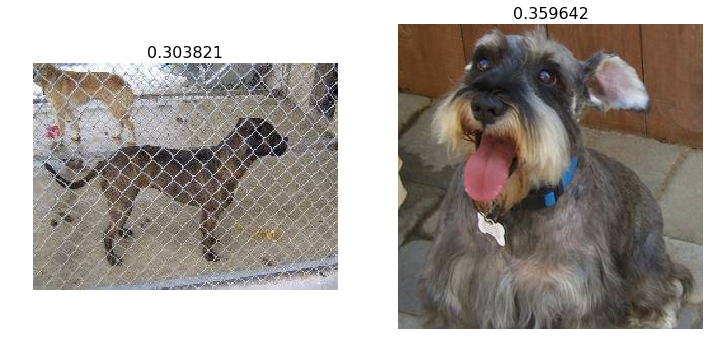

In [391]:
incorrect_cats = np.where((predicted_classes==0) & (predicted_classes!=actual_classes))[0]
print '{} incorrect cats found'.format(len(incorrect_cats))
plot_idxs(incorrect_cats)

36 correct predictions found


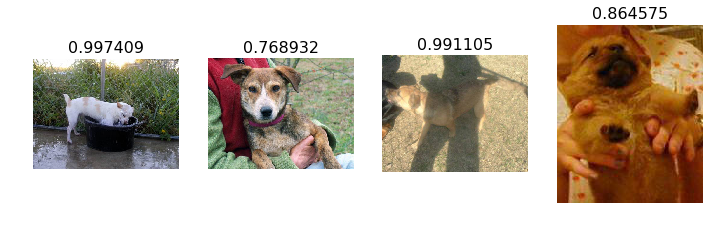

In [392]:
correct_dogs = np.where((predicted_classes==1) & (predicted_classes==actual_classes))[0]
print '{} correct predictions found'.format(len(correct_dogs))
plot_idxs(correct_dogs)

2 incorrect dogs found


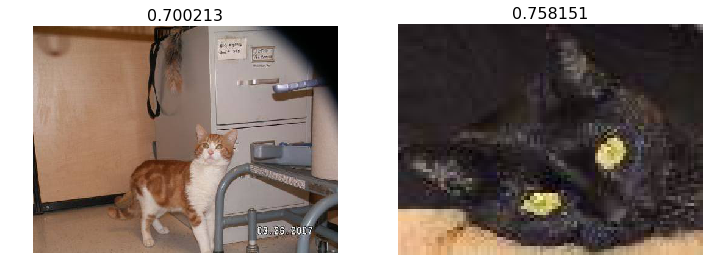

In [393]:
incorrect_dogs = np.where((predicted_classes==1) & (predicted_classes!=actual_classes))[0]
print '{} incorrect dogs found'.format(len(incorrect_dogs))
plot_idxs(incorrect_dogs)

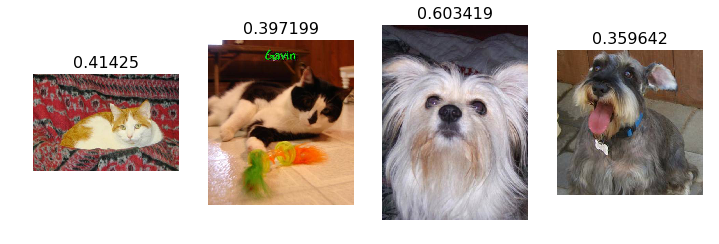

In [394]:
most_uncertain = np.argsort(np.abs(probabilities_of_dog-0.5))
plot_idxs(most_uncertain[:4])

[[40  2]
 [ 2 36]]


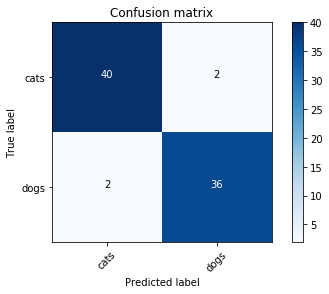

In [395]:
from sklearn.metrics import confusion_matrix
from utils import plot_confusion_matrix

cm = confusion_matrix(actual_classes, predicted_classes)
plot_confusion_matrix(cm, test_batches.class_indices)

In [406]:
from sklearn.metrics import precision_score, log_loss, recall_score

precision = precision_score(actual_classes, predicted_classes);
recall = recall_score(actual_classes, predicted_classes)
f1 = (2 * precision * recall) / (precision + recall)

print 'Precision score: {:.4f}%'.format(precision)
print 'Recall score: {:.4f}%'.format(recall)
print 'F1: {:.4f}%'.format(f1)

print 'Log Loss: {:.4f}%'.format(log_loss(actual_classes, probabilities_of_dog))
adjusted_probs = probabilities_of_dog.clip(min=0.05, max=0.95)
print 'Adjusted Log Loss: {:.4f}%'.format(log_loss(actual_classes, probabilities_of_dog.clip(min=0.05, max=0.95)))

Precision score: 0.9474%
Recall score: 0.9474%
F1: 0.9474%
Log Loss: 0.1261%
Adjusted Log Loss: 0.1573%


# Run predicitons on test set and create csv for submission

In [407]:
# we can continue from this step if we already previously trained model
vgg.model.load_weights(latest_weights_filename)

In [408]:
test_path = path + '/test'
test_batches = vgg.get_batches(test_path, batch_size=batch_size, shuffle=False)

Found 80 images belonging to 1 classes.


In [409]:
predicting_start_time = time.time()
predictions = vgg.model.predict_generator(test_batches, test_batches.nb_sample)
print 'Prediction took {}s'.format(int(time.time() - predicting_start_time))
probabilities_of_dog = predictions[:,1]

Prediction took 24s


In [414]:
results_file = path + '/results/submission.csv'
file = open(results_file, "wb")
writer = csv.writer(file, delimiter=',', quoting=csv.QUOTE_NONE)
writer.writerow(["id", "label"])

sample_idx = 0
for filename in test_batches.filenames:
    sample_id = filename.replace("unknown/", "").replace(".jpg", "")
    writer.writerow([sample_id, probabilities_of_dog[sample_idx]])
    sample_idx += 1

file.close()

In [420]:
from IPython.display import FileLink
%cd $LESSON_HOME
relative_path_to_results = results_file.replace(LESSON_HOME, '')[1:]
FileLink(relative_path_to_results)

/Users/chekalin/Dev/fastai/fast-ai-homework/lesson1hw


/Users/chekalin/Dev/fastai/fast-ai-homework/lesson1hw/data/sample/results/submission.csv